# Project Part 2 Solutions

## (a)

In [122]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]
file.files
Svc_0_PMF.shape[1]


4

In [123]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [124]:
def SIR1(t, Z, N, betas, gamma,alpha):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -(betas*alpha)*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [231]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate((Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]
    #breakpoint()


alpha_predited = np.zeros((nb_nodes))
R[0,10]

0.0

In [126]:
from random import seed
from random import random
def loss_func(alpha,node_index):
    initial_conditions = np.concatenate((Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))
    soln = solve_ivp(SIR1, (t[10], t[29]), initial_conditions, args=(N_node, beta_old, gamma,alpha), t_eval=t[10:29])

    S[node_index, :, :, 10:29] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 10:29] = soln.y[16:20]
    R[node_index, 10:29] = soln.y[20]
    L[node_index, 10:29] = Lc@soln.y[16:20]
    Lpredicted=L[node_index, 10:29]
    mse= mean_squared_error(Lpredicted,L_observed[node_index,10:29])
    #breakpoint()
    return mse


#seed(1)
for x in range (10):
    q=random()
    a=loss_func(q,30)
    print("MSE",a)
    print("Alpha",q)



#for N_node, node_index in zip(N, range(nb_nodes)):
    #alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)


MSE 214696.2092073958
Alpha 0.2962845361031051
MSE 147906.21997110773
Alpha 0.39858431977072595
MSE 118544.72783109997
Alpha 0.4941454607201421
MSE 185546.19059853905
Alpha 0.3402353016144063
MSE 251249.43221786394
Alpha 0.23680497931696265
MSE 1442335.0642876253
Alpha 0.7352707920458275
MSE 11254459.71246635
Alpha 0.9805424943998533
MSE 10763587.884813318
Alpha 0.9730764979823034
MSE 310320.98231061635
Alpha 0.11475526065326769
MSE 246039.9263657009
Alpha 0.24576638113589777


In [127]:
alpha_predicted[0]


0.12352142333984342

In [131]:
for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5,args=(node_index,N_node,),disp=False)
    #breakpoint()


In [132]:
q=alpha_predicted[2]
a=loss_func(q,2,N[2])
print("MSE",a)
print("Alpha",q)
sorted_alphas=alpha_predicted
sorted_alphas.sort()
print("Nodes ranked by how high theyre alphas is",sorted_alphas)

MSE 19.98025942448137
Alpha 0.22185058593749976
Nodes ranked by how high theyre alphas is [0.12352142 0.13822021 0.14249268 0.14443359 0.14606934 0.14807129
 0.15137939 0.15171814 0.1552803  0.16387329 0.16503143 0.16713867
 0.17045288 0.17644043 0.18051758 0.19622192 0.20018311 0.20029602
 0.20103149 0.20452881 0.20931396 0.20965576 0.21018066 0.22185059
 0.22246094 0.22650146 0.22669983 0.23173828 0.23728027 0.24645996
 0.24889221 0.25011292 0.25706787 0.26390381 0.26639404 0.26811523
 0.27178955 0.27543945 0.27561264 0.27568665 0.28189697 0.28358765
 0.28780823 0.2932373  0.29797363 0.3010498  0.30296936 0.31580811
 0.32045898 0.3225708  0.32358704 0.33059082 0.330896   0.33418884
 0.33525391 0.33642883 0.34067383 0.35007172 0.35155029 0.35754395
 0.3601532  0.36387939 0.37408447 0.3757782  0.38779907 0.39297028
 0.39484253 0.41170807 0.41690369 0.41756592 0.42473755 0.43126221
 0.43154907 0.44144897 0.44838867 0.45488892 0.46865234 0.49281006
 0.51626587 0.51790771 0.52313232 0.535

In [133]:
from random import seed
from random import random
def loss_func(alpha,node_index,N):
    initial_conditions = np.concatenate((S[node_index,:,:,9].flatten(), I[node_index,:,9], [R[node_index,9]]))
    soln = solve_ivp(SIR1, (t[10], t[29]), initial_conditions, args=(N, beta_old, gamma,alpha), t_eval=t[10:30])

    S[node_index, :, :, 10:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 10:30] = soln.y[16:20]
    R[node_index, 10:30] = soln.y[20]
    L[node_index, 10:30] = Lc@soln.y[16:20]
    Lpredicted=L[node_index, 10:30]
    mse= mean_squared_error(Lpredicted,L_observed[node_index,10:30])
    #breakpoint()
    return mse


## (b)

In [141]:
'''n=g_inv(A0[39])
nm=n+10000
m=g(nm)
An=g_inv(m)
print(m) '''

'n=g_inv(A0[39])\nnm=n+10000\nm=g(nm)\nAn=g_inv(m)\nprint(m) '

In [279]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money
    import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(sorted_alphas,A1, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")
    #plt.axis([0, 1, 0, 1])
    
def total_recovered_difference(alpha_afterNPI):
    t = np.linspace(0, 199, 200)
    #initial_conditions = np.concatenate((Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))
    #soln = solve_ivp(SIR1, (t[0], t[199]), initial_conditions, args=(N_node, beta_old, gamma,alpha_afterNPI), t_eval=t[0:199])
    #S[node_index, :, :, 0:199] = soln.y[:100]
    #sorteda=soln.y[:100]
    #sorted_alphas.reshape(1,100)
    
    for N_node, node_index in zip(N, range(nb_nodes)):

        initial_conditions = np.concatenate((Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

        soln = solve_ivp(SIR, (t[0], t[199]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[0:199])

        S[node_index, :, :, :199] = soln.y[:16].reshape(4,4,-1)
        I[node_index, :, :199] = soln.y[16:20]
        R[node_index, :199] = soln.y[20]
        L[node_index, :199] = Lc@soln.y[16:20]
    #breakpoint()
    beforeNPI=R
    
    
    for N_node, node_index in zip(N, range(nb_nodes)):

        initial_conditions1 = np.concatenate((Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))
        #breakpoint()
        
        soln1 = solve_ivp(SIR1, (t[0], t[199]), initial_conditions1, args=(N_node, beta_old, gamma,alpha_afterNPI), t_eval=t[0:199])
        #need to reshape alpha_afterNPI
        S[node_index, :, :, :199] = soln1.y[:16].reshape(4,4,-1)
        I[node_index, :, :199] = soln1.y[16:20]
        R[node_index, :199] = soln1.y[20]
        L[node_index, :199] = Lc@soln1.y[16:20]
        R1=soln1.y[16:20]
        
    afterNPI=R1
    
    
    
    difference = afterNPI#(S- alpha_afterNPI)
    
    return difference

### Policy #1

In [184]:
#i.
A1=[]
Newmoney=[]
for r in range(100):
    n=g_inv(sorted_alphas[r])
    nm=n+10000
    An=g(nm)
    m=g_inv(An)
    A1.append(An)
    Newmoney.append(m)


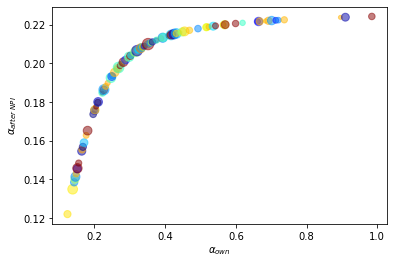

In [185]:
import matplotlib.pyplot as plt
scatter_plot(A1)

In [278]:
#ii
total_recovered_difference(A1)


> <ipython-input-277-b80b9156ecde>(45)total_recovered_difference()
     43         breakpoint()
     44 
---> 45         soln1 = solve_ivp(SIR1, (t[0], t[199]), initial_conditions1, args=(N_node, beta_old, gamma,alpha_afterNPI), t_eval=t[0:199])
     46 
     47         S[node_index, :, :, :199] = soln1.y[:16].reshape(4,4,-1)

ipdb> alpha_afterNPI
[0.1219875708991558, 0.13486726171284277, 0.1384092366477121, 0.1399851549146592, 0.14129673436615253, 0.14288097310278913, 0.14544722861632917, 0.14570632887451385, 0.1483889308889189, 0.15453821780678845, 0.1553317326647037, 0.15675392362658838, 0.15893428981679036, 0.1626992994633484, 0.16513613981516034, 0.17359787049537367, 0.17551166465159077, 0.175564979615867, 0.1759105903576458, 0.17751522258410368, 0.17960965918500335, 0.1797549137461394, 0.1799768752994217, 0.1845796247459983, 0.1848036501327059, 0.18624729781578642, 0.18631644128928435, 0.18802031001328717, 0.18978292912765873, 0.1924652521009385, 0.19312980115753392, 0.1934564257

BdbQuit: 

### Policy #2

In [203]:
#i
N_percent=N/2714267.352274217
money=N_percent*1000000
A2=[]
Newmoney=[]
for r in range(100):
    n=g_inv(sorted_alphas[r])
    nm=n+money[r]
    An=g(nm)
    m=g_inv(An)
    A2.append(An)
    Newmoney.append(m)

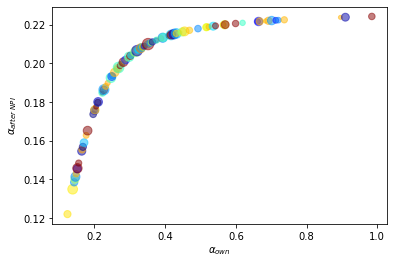

In [204]:
import matplotlib.pyplot as plt
scatter_plot(A2)

ii.

### Policy #3

i.

ii.

### Policy #4

i.

ii.

## (c)

### Policy 1

### Policy 2

### Policy 3

### Policy 4